In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Self_Attention(nn.Module):
    def __init__(self, embed_size, heads):
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        answer = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape : (N, query_len, heads, head_dim)
        # keys shape : (N, key_len, heads, head_dim)
        # answer shape : (N, heads, query_len, key_len)

        if mask is not None:
            answer = answer.masked_fill(mask == 0, float("-1e20"))
        
        attention = torch.softmax(answer / (self.embed_size ** (1/2)), dim = 3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values])
        out = out.reshape(N, query_len, self.heads * self.head_dim)
        # attention shape : (N, heads, query_len, key_len)
        # values shape : (N, value_len, heads, head_dim)
        # out shape : (N, query_len, head, head_dim) and the flatten last 2 dimensions
        
        out = self.fc_out(out)
        return out

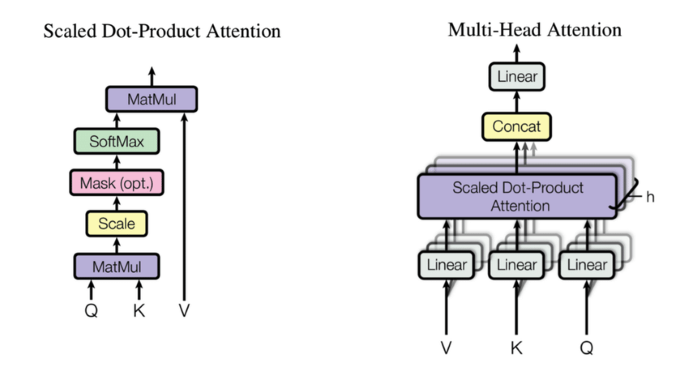

In [ ]:
class Transformer_Block(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(Transformer_Block, self).__init()
        self.attention = Self_Attention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size), # forward_expansion is 4 which is used in original paper
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        norm1 = self.norm1(attention + query)
        x = self.dropout(norm1) 
        forward = self.feed_forward(x)
        norm2 = self.norm2(forward + x)
        out = self.dropout(norm2)
        return out

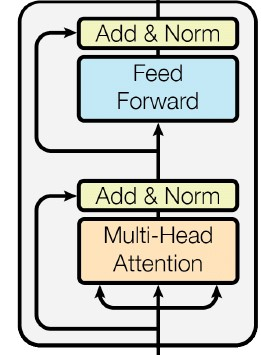

In [ ]:
class Encoder(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            embed_size, 
            num_layers,
            heads,
            forward_expansion,
            dropout,
            max_length,
            device,
    ):
        super(Encoder, self).__init()
        self.embed_size = embed_size
        self.word_embeddings = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                Transformer_Block(
                    embed_size,
                    heads,
                    dropout = dropout,
                    forward_expansion = forward_expansion
                )
            ]
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        word_embedding = self.word_embedding(x)
        position_embedding = self.position_embedding(positions)
        out = self.dropout(word_embedding + position_embedding)

        for layer in layers:
            out = layer(out, out, out, mask)
        
        return out

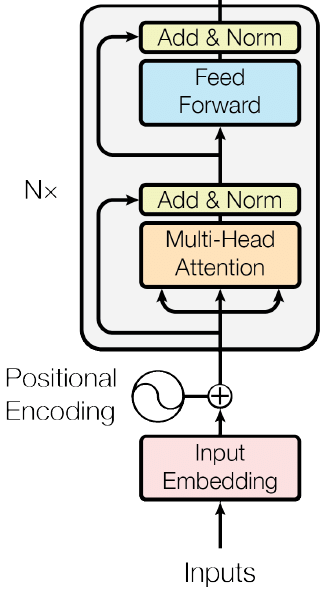

In [ ]:
class Decoder_Block(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(Decoder_Block, self).__init__()
        self.attention = Self_Attention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = Transformer_Block(embed_size, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out =  self.transformer_block(value, key, query, src_mask)
        return out

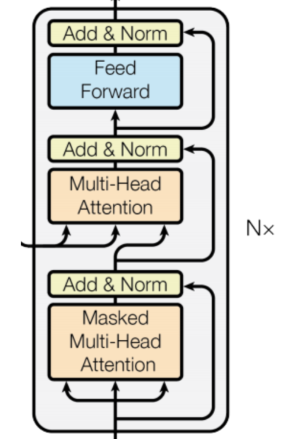

In [ ]:
class Decoder(nn.Module):
    def __init__(
            self,
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.Modulelist(
            [Decoder_Block(embed_size, heads, forward_expansion, dropout, device)
            for _ in range(num_layers)]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq).expand(N, seq_length).to(self.device)
        word_embedding = self.word_embedding(x)
        position_embedding = self.position_embedding(positions)
        out = self.dropout(word_embedding + position_embedding)

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        
        out = self.fc_out(x)
        return out

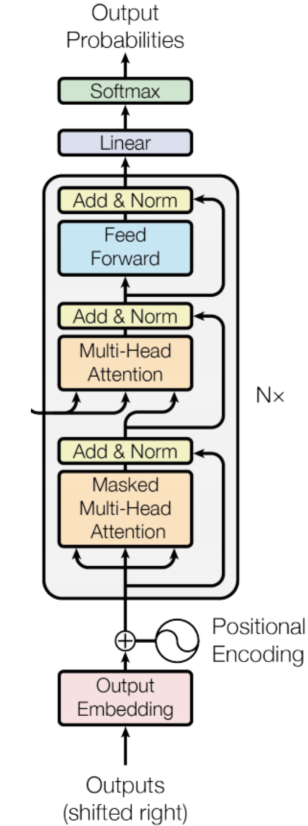

In [ ]:
class Transformer(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            trg_vocab_size,
            src_pad_idx,
            trg_pad_idx,
            embed_size = 512,
            num_layers = 6,
            forward_expansion = 4,
            heads = 8, 
            dropout = 0,
            device = "cuda",
            max_length = 100
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
                src_vocab_size,
                embed_size, 
                num_layers,
                heads,
                forward_expansion,
                dropout,
                max_length,
                device,  
        )
        self.decoder = Decoder(
                trg_vocab_size,
                embed_size,
                num_layers,
                heads,
                forward_expansion,
                dropout,
                device,
                max_length
        )
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

        def make_src_mask(self, src):
            src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
            return src_mask.to(self.device)
        
        def make_trg_mask(self, trg):
            N, trg_len = trg.shape
            trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
                N, 1, trg_len, trg_len
            )
            return trg_mask.to(self.device)
        
        def forward(self, src, trg):
            src_mask = self.make_src_mask(src)
            trg_mask = self.make_trg_mask(trg)
            enc_src = self.encoder(src, src_mask)
            out = self.decoder(trg, enc_src, src_mask, trg_mask)
            return out

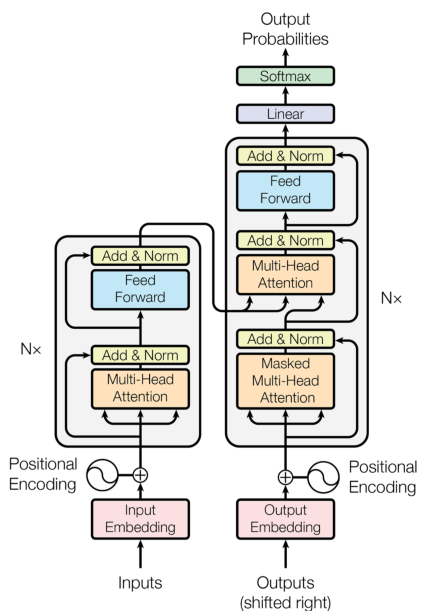